# MNIST Digit Classification - CNN

In [1]:
from __future__ import division, print_function
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch.autograd import Variable
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

MODEL_FILE = os.path.join(DATA_DIR, "torch-mnist-cnn-{:d}.model")

LEARNING_RATE = 0.001
INPUT_SIZE = 28
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 5

## Prepare Data

Image data needs to be in Theano ordering format, ie, (batch_size, num_channels, width, height).

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        xs1d = np.array([float(x) / 255. for x in cols[1:]])
        xs3d = np.reshape(xs1d, (1, INPUT_SIZE, INPUT_SIZE))
        xdata.append(xs3d)
        i += 1
    fin.close()
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    X = np.array(xdata)
    y = np.array(ydata)
    return X, y

Xtrain, ytrain = parse_file(TRAIN_FILE)
Xtest, ytest = parse_file(TEST_FILE)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(60000, 1, 28, 28) (60000,) (10000, 1, 28, 28) (10000,)


In [4]:
def datagen(X, y, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES):
    ohe = OneHotEncoder(n_values=num_classes)
    while True:
        shuffled_indices = np.random.permutation(np.arange(len(y)))
        num_batches = len(y) // batch_size
        for bid in range(num_batches):
            batch_indices = shuffled_indices[bid*batch_size:(bid+1)*batch_size]
            Xbatch = np.zeros((batch_size, 1, INPUT_SIZE, INPUT_SIZE))
            Ybatch = np.zeros((batch_size, num_classes))
            for i in range(batch_size):
                Xbatch[i] = X[batch_indices[i]]
                Ybatch[i] = ohe.fit_transform(y[batch_indices[i]]).todense()
            yield Xbatch, Ybatch

self_test_gen = datagen(Xtrain, ytrain)
Xbatch, Ybatch = self_test_gen.next()
print(Xbatch.shape, Ybatch.shape)

(128, 1, 28, 28) (128, 10)


## Define Network

In [5]:
class MNIST_CNN(torch.nn.Module):
    
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # CONV-1: 5x5 kernel, channels 1 => 32, maxpool(size=2)
        self.layer_conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        # CONV-2: 5x5 kernel, channels 32 => 64, maxpool(size=2)
        self.layer_conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        # FC1: input=(None, 7, 7, 64), output=(None, 1024)
        self.layer_fc1 = torch.nn.Sequential(
            torch.nn.Linear(7*7*64, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25))
        # Output, class prediction (1024 => 10)
        self.layer_pred = torch.nn.Sequential(
            torch.nn.Linear(1024, 10),
            torch.nn.Softmax())

    def forward(self, x):
        conv1 = self.layer_conv1(x)
        conv2 = self.layer_conv2(conv1)
        flatten = conv2.view(conv2.size(0), -1)
        fc1 = self.layer_fc1(flatten)
        pred = self.layer_pred(fc1)
        return pred

model = MNIST_CNN()

In [6]:
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train Network

In [7]:
def compute_accuracy(pred_var, true_var):
    ypred = np.argmax(pred_var.data.numpy(), axis=1)
    ytrue = np.argmax(true_var.data.numpy(), axis=1)
    return accuracy_score(ypred, ytrue)

history = []
train_gen = datagen(Xtrain, ytrain, BATCH_SIZE)
for epoch in range(NUM_EPOCHS):
    num_batches = len(Xtrain) // BATCH_SIZE
    total_loss, total_acc = 0., 0.
    for _ in range(num_batches):
        Xbatch, Ybatch = train_gen.next()
        # convert to Torch datatype
        Xbatch = Variable(torch.from_numpy(Xbatch).float())
        Ybatch = Variable(torch.from_numpy(Ybatch).float())
        # forward + backward + optimize
        optimizer.zero_grad()
        Ybatch_ = model(Xbatch)
        loss = loss_fn(Ybatch_, Ybatch)
        loss.backward()
        total_loss += loss.data[0]
        total_acc += compute_accuracy(Ybatch_, Ybatch)
        optimizer.step()
        
    total_loss /= num_batches
    total_acc /= num_batches
    torch.save(model, MODEL_FILE.format(epoch+1))

    print("Epoch {:d}/{:d}: loss={:.3f}, accuracy={:.3f}".format(
            (epoch+1), NUM_EPOCHS, total_loss, total_acc))
    history.append((total_loss, total_acc))

/Users/palsujit/anaconda/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type MNIST_CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1/5: loss=0.008, accuracy=0.946
Epoch 2/5: loss=0.002, accuracy=0.984
Epoch 3/5: loss=0.002, accuracy=0.989
Epoch 4/5: loss=0.001, accuracy=0.992
Epoch 5/5: loss=0.001, accuracy=0.993


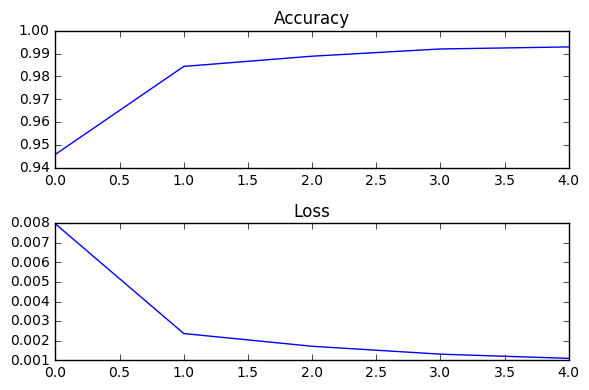

In [8]:
losses = [x[0] for x in history]
accs = [x[1] for x in history]

plt.subplot(211)
plt.title("Accuracy")
plt.plot(accs)

plt.subplot(212)
plt.title("Loss")
plt.plot(losses)

plt.tight_layout()
plt.show()

## Evaluate Network

In [9]:
BEST_MODEL_FILE = os.path.join(DATA_DIR, "torch-mnist-cnn-5.model")
model = torch.load(BEST_MODEL_FILE)

ys_, ys = [], []
test_gen = datagen(Xtest, ytest, BATCH_SIZE)
num_batches = len(Xtest) // BATCH_SIZE
for _ in range(num_batches):
    Xbatch, Ybatch = test_gen.next()
    Xbatch = Variable(torch.from_numpy(Xbatch).float())
    Ybatch = Variable(torch.from_numpy(Ybatch).float())
    Ybatch_ = model(Xbatch)
    ys_.extend(np.argmax(Ybatch_.data.numpy(), axis=1))
    ys.extend(np.argmax(Ybatch.data.numpy(), axis=1))

acc = accuracy_score(ys_, ys)
cm = confusion_matrix(ys_, ys)
print("Accuracy: {:.4f}".format(acc))
print("Confusion Matrix")
print(cm)

Accuracy: 0.9858
Confusion Matrix
[[ 974    0    0    1    0    1    1    0    3    0]
 [   0 1127    0    0    0    0    2    1    0    2]
 [   4    0 1025    0    0    0    0    4   29    5]
 [   0    1    0 1000    0    3    0    0    7    1]
 [   0    0    0    0  979    0    1    0    2   14]
 [   0    1    0    6    0  883    5    0   13    7]
 [   0    1    0    0    1    1  947    0    2    0]
 [   0    3    4    1    0    1    0 1021    2    4]
 [   0    0    0    1    0    0    0    0  911    0]
 [   0    0    0    0    2    0    0    1    4  975]]
